<a href="https://colab.research.google.com/github/bindukovvada/Book-Recommendation-System/blob/main/Team_Book_Recommendation_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**BOOK RECOMMENDATION SYSTEM**

#Problem Statement
During the last few decades, with the rise of Youtube, Amazon, Netflix, and many other such
web services, recommender systems have taken more and more place in our lives. From
e-commerce (suggest to buyers articles that could interest them) to online advertisement
(suggest to users the right contents, matching their preferences), recommender systems are
today unavoidable in our daily online journeys.


In a very general way, recommender systems are algorithms aimed at suggesting relevant
items to users (items being movies to watch, text to read, products to buy, or anything else
depending on industries).
Recommender systems are really critical in some industries as they can generate a huge
amount of income when they are efficient or also be a way to stand out significantly from
competitors. The main objective is to create a book recommendation system for users.


#Content
The Book-Crossing dataset comprises 3 files.

● Users
Contains the users. Note that user IDs (User-ID) have been anonymized and map to
integers. Demographic data is provided (Location, Age) if available. Otherwise, these
fields contain NULL values.

● Books
Books are identified by their respective ISBN. Invalid ISBNs have already been removed
from the dataset. Moreover, some content-based information is given (Book-Title,
Book-Author, Year-Of-Publication, Publisher), obtained from Amazon Web
Services. Note that in the case of several authors, only the first is provided. URLs linking
to cover images are also given, appearing in three different flavors (Image-URL-S,
Image-URL-M, Image-URL-L), i.e., small, medium, large. These URLs point to the
Amazon website.

● Ratings
Contains the book rating information. Ratings (Book-Rating) are either explicit,
expressed on a scale from 1-10 (higher values denoting higher appreciation), or implicit,
expressed by 0.

#Table of content
* __Step 1: Importing the Relevant Libraries and Data Inspection__
    
* __Step 2: Exploratory Data Analysis (Dataset-wise)__
    
* **Step 3: Recommendation for New Users(Cold Start)**
    
* **Step 4: Model Based Collaborative Filtering Recommender**

* __Step 5: Memory Based Collaborative Filtering Recommender__

  *   Item-Item Based
  *   Item-Item Based- Second Method
  *   User-Item Based
   
* __Step 6: Content Based Filtering Recommender__

    *  On the basis of Title
    *  On the basis of Author
    *  On the basis of Search-Keyword
      * Via TF-idf
      * **Via Tags**
    *  On the basis of Purchase-History

* __Step 7: Conclusion__

#**Importing and Inspecting Dataset**

In [1]:
#Importing modules
import pandas as pd
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import math

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import linear_kernel
from scipy.sparse.linalg import svds
# This is to supress the warning messages (if any) generated in our code
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm  #(progress bar)


In [2]:
# connnecting drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
books=pd.read_csv('/content/drive/MyDrive/Capstone Project - 4/Copy of Books.csv')
ratings=pd.read_csv('/content/drive/MyDrive/Capstone Project - 4/Copy of Ratings.csv')
users=pd.read_csv('/content/drive/MyDrive/Capstone Project - 4/Copy of Users.csv')

### Data Inspection

In [4]:
books.head(3)

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...


In [5]:
ratings.head(3)

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0


In [6]:
users.head(3)

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN


In [7]:
# dimension of dataset
print(f'''\t  Book_df shape is {books.shape}
       Ratings_df shape is {ratings.shape}
          Users_df shape is {users.shape}''')

	  Book_df shape is (271360, 8)
       Ratings_df shape is (1149780, 3)
          Users_df shape is (278858, 3)


#**EDA**

##**1- Users_Dataset**

In [8]:
#Create a function for checking missing values
def missing_values(df):
    mis_val=df.isnull().sum()
    mis_val_percent=round(df.isnull().mean().mul(100),2)
    mz_table=pd.concat([mis_val,mis_val_percent],axis=1)
    mz_table=mz_table.rename(
    columns={df.index.name:'col_name',0:'Missing Values',1:'% of Total Values'})
    mz_table['Data_type']=df.dtypes
    mz_table=mz_table.sort_values('% of Total Values',ascending=False)
    return mz_table.reset_index()

In [9]:
#Checking missing value in Users dataset
missing_values(users)

,index,Missing Values,% of Total Values,Data_type
0,Age,110762,39.72,float64
1,User-ID,0,0.00,int64
2,Location,0,0.00,object


Age have around 39% missing values. 

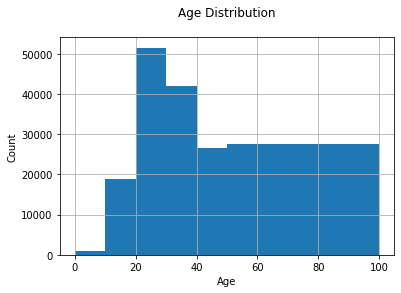

In [10]:
#checking Age distribution
users.Age.hist(bins=[0, 10, 20, 30, 40, 50, 100])
plt.title('Age Distribution\n')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

As we can see that most of our users are in their 20-30s.


Text(0.5, 1.0, 'Find outlier data in Age column')

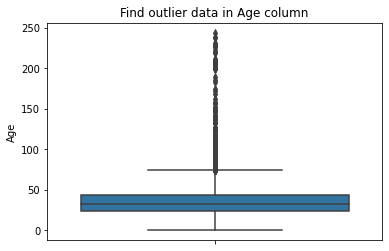

In [11]:
#Checking Outliers in Age Column
sns.boxplot(y='Age', data=users)
plt.title('Find outlier data in Age column')

In [12]:
#Checking the unique value of Age
print(sorted(users.Age.unique()))

[nan, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0, 101.0, 102.0, 103.0, 104.0, 105.0, 106.0, 107.0, 108.0, 109.0, 110.0, 111.0, 113.0, 114.0, 115.0, 116.0, 118.0, 119.0, 123.0, 124.0, 127.0, 128.0, 132.0, 133.0, 136.0, 137.0, 138.0, 140.0, 141.0, 143.0, 146.0, 147.0, 148.0, 151.0, 152.0, 156.0, 157.0, 159.0, 162.0, 168.0, 172.0, 175.0, 183.0, 186.0, 189.0, 199.0, 200.0, 201.0, 204.0, 207.0, 208.0, 209.0, 210.0, 212.0, 219.0, 220.0, 223.0, 226.0

As we can say that we have  Outlier in our dataset of users

Checking unique value in Location column....


In [13]:
users.Location.unique()

array(['nyc, new york, usa', 'stockton, california, usa',
       'moscow, yukon territory, russia', ...,
       'sergnano, lombardia, italy', 'stranraer, n/a, united kingdom',
       'tacoma, washington, united kingdom'], dtype=object)

As we can see that there is some spelling mismatch in locations... so now lets check the unique count of Location....

In [14]:
users.Location.nunique()

57339

We got 57339 unique Value as we all know that it doesn't make any sense.<br>
So lets create a new column- Country

In [15]:
for i in users:
    users['Country']=users.Location.str.extract(r'\,+\s?(\w*\s?\w*)\"*$')   

In [16]:
type(users.Location)

pandas.core.series.Series

In [17]:
users.Country.nunique()

529

Now we only got 529 unique country.

In [18]:
users['Country']=users['Country'].astype('str')

In [19]:
a=list(users.Country.unique())
a=set(a)
a=list(a)
a = [x for x in a if x is not None]
a.sort()
print(a)

['', '01776', '02458', '19104', '23232', '30064', '85021', '87510', '_ brasil', 'a', 'aaa', 'adsgfdr', 'afghanistan', 'ahrensburg', 'alachua', 'albania', 'alderney', 'algeria', 'algérie', 'allen', 'ama lurra', 'america', 'american samoa', 'andorra', 'angola', 'antarctica', 'aotearoa', 'argentina', 'armenia', 'aroostook', 'aruba', 'asturies', 'auckland', 'austbritania', 'australia', 'australii', 'austria', 'autralia', 'az', 'azerbaijan', 'bademn würtemberg', 'bahamas', 'bahrain', 'baltimore', 'bangladesh', 'barbados', 'basilicata', 'basque country', 'bavaria', 'baxter', 'bbbzzzzz', 'belarus', 'belgi', 'belgique', 'belgium', 'belize', 'bell', 'benin', 'berguedà', 'bermuda', 'bernalillo', 'bfe', 'bhutan', 'bih', 'bkk', 'bladen', 'bolivia', 'bosnia', 'botswana', 'brasil', 'brazil', 'brunei', 'brunei darussalam', 'bucks', 'bulgaria', 'buncombe', 'burkina faso', 'burkinafasu', 'burlington', 'burma', 'butler', 'c', 'cadd0', 'calabria', 'california', 'cambodia', 'camden', 'cameroon', 'can', 'c

As we can Obseve here are some Misspellings we can easily correct them via replace.

In [20]:
users['Country'].replace(['','01776','02458','19104','23232','30064','85021','87510','alachua','america','austria','autralia','cananda','geermany','italia','united kindgonm','united sates','united staes','united state','united states','us'],
                           ['other','usa','usa','usa','usa','usa','usa','usa','usa','usa','australia','australia','canada','germany','italy','united kingdom','usa','usa','usa','usa','usa'],inplace=True)

Text(0.5, 1.0, 'Count of users Country wise')

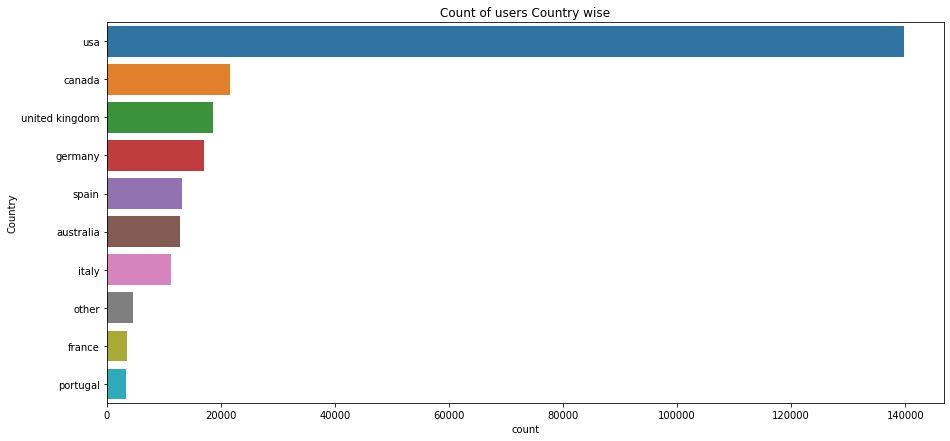

In [21]:
plt.figure(figsize=(15,7))
sns.countplot(y='Country',data=users,order=pd.value_counts(users['Country']).iloc[:10].index)
plt.title('Count of users Country wise')

We can clearly observe from the above countplot that most of our customers are 
from US.

In [22]:
#drop location column
users.drop('Location',axis=1,inplace=True)

In [23]:
# Checking null values of users
users.isnull().sum()

User-ID         0
Age        110762
Country         0
dtype: int64

###Treating Outliers----

Text(0.5, 1.0, 'Age Distribution Plot')

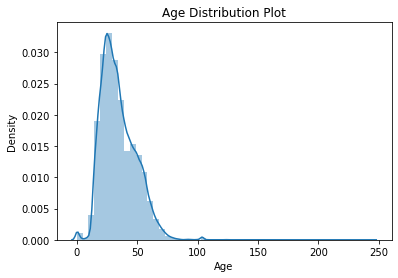

In [24]:
#Distplot of users age column
sns.distplot(users.Age)
plt.title('Age Distribution Plot')

As we all knew already that Age value's below 5 and above 100 do not make much sense as the can't read/rated our book so we can replace that.

In [25]:
5|6

7

In [26]:
# outlier data became NaN
users.loc[(users.Age > 100) | (users.Age < 5), 'Age'] = np.nan

In [27]:
#Checking null values again in Users dataset
users.isna().sum()

User-ID         0
Age        112010
Country         0
dtype: int64

Age has positive Skewness (right tail)
so we can use median to fill Nan values,
but for this we don't like to fill Nan value just for one range of age. To handle this we'll use country column to fill Nan.

In [28]:
users['Age'] = users['Age'].fillna(users.groupby('Country')['Age'].transform('median'))

In [29]:
#Checking null value again
users.isna().sum()

User-ID      0
Age        276
Country      0
dtype: int64

Still we have 276 Nan values let's fill them with mean

In [30]:
users['Age'].fillna(users.Age.mean(),inplace=True)

In [31]:
#again checking value
users.isna().sum()

User-ID    0
Age        0
Country    0
dtype: int64

##**2- Books_Dataset**

In [32]:
#head of books dataset
books.head(2)

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...


Let's find our Top 10 Authors which have written the most books--

In [33]:
books.shape

(271360, 8)

In [34]:
len(books['Book-Author'].unique())

102024

Top 10 Authors which have published the most books:

Text(0.5, 1.0, 'Top 10 Authors')

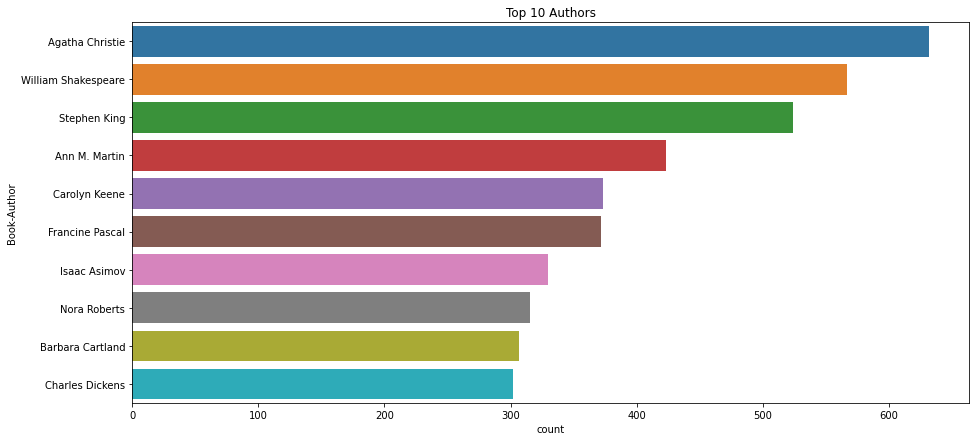

In [35]:
plt.figure(figsize=(15,7))
sns.countplot(y='Book-Author',data=books,order=pd.value_counts(books['Book-Author']).iloc[:10].index)
plt.title('Top 10 Authors')

Top 10 Publisher which have published the most books:

Text(0.5, 1.0, 'Top 10 Publishers')

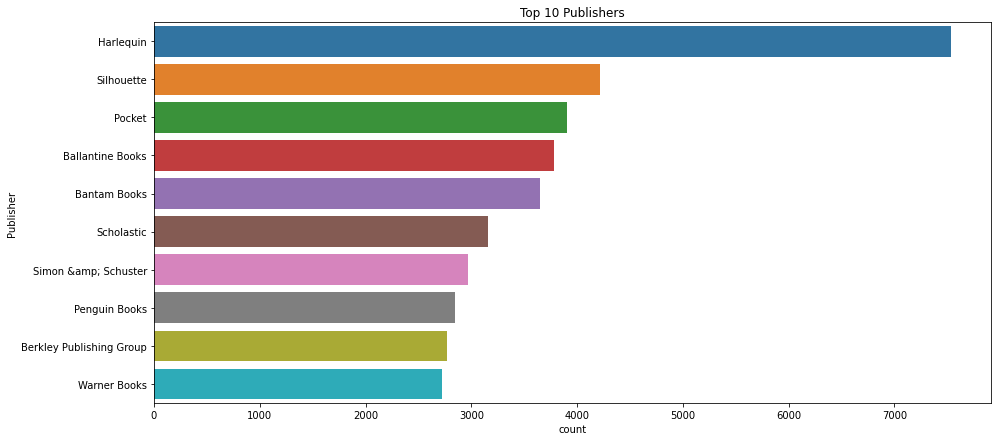

In [36]:
plt.figure(figsize=(15,7))
sns.countplot(y='Publisher',data=books,order=pd.value_counts(books['Publisher']).iloc[:10].index)
plt.title('Top 10 Publishers')

In [37]:
books['Year-Of-Publication']=books['Year-Of-Publication'].astype('str')
a=list(books['Year-Of-Publication'].unique())
a=set(a)
a=list(a)
a = [x for x in a if x is not None]
a.sort()
print(a)

['0', '1376', '1378', '1806', '1897', '1900', '1901', '1902', '1904', '1906', '1908', '1909', '1910', '1911', '1914', '1917', '1919', '1920', '1921', '1922', '1923', '1924', '1925', '1926', '1927', '1928', '1929', '1930', '1931', '1932', '1933', '1934', '1935', '1936', '1937', '1938', '1939', '1940', '1941', '1942', '1943', '1944', '1945', '1946', '1947', '1948', '1949', '1950', '1951', '1952', '1953', '1954', '1955', '1956', '1957', '1958', '1959', '1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968', '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2008', '2010', '2011', '2012', '2020', '2021', '2024', '2026', '2030', '2037', '2038', '2050', 'DK Publishing Inc', 'Gallimard']


In [38]:
#investigating the rows having 'DK Publishing Inc' as yearOfPublication
books.loc[books['Year-Of-Publication'] == 'DK Publishing Inc',:]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
209538,078946697X,"DK Readers: Creating the X-Men, How It All Beg...",2000,DK Publishing Inc,http://images.amazon.com/images/P/078946697X.0...,http://images.amazon.com/images/P/078946697X.0...,http://images.amazon.com/images/P/078946697X.0...,NaN
221678,0789466953,"DK Readers: Creating the X-Men, How Comic Book...",2000,DK Publishing Inc,http://images.amazon.com/images/P/0789466953.0...,http://images.amazon.com/images/P/0789466953.0...,http://images.amazon.com/images/P/0789466953.0...,NaN


As it can be seen from above that there are some incorrect entries in Year-Of-Publication field. It looks like Publisher names 'DK Publishing Inc' and 'Gallimard' have been incorrectly loaded as Year-Of-Publication in dataset due to some errors in csv file 

In [39]:
#From above, it is seen that bookAuthor is incorrectly loaded with bookTitle, hence making required corrections
#ISBN '0789466953'
books.loc[books.ISBN == '0789466953','Year-Of-Publication'] = 2000
books.loc[books.ISBN == '0789466953','Book-Author'] = "James Buckley"
books.loc[books.ISBN == '0789466953','Publisher'] = "DK Publishing Inc"
books.loc[books.ISBN == '0789466953','Book-Title'] = "DK Readers: Creating the X-Men, How Comic Books Come to Life (Level 4: Proficient Readers)"

#ISBN '078946697X'
books.loc[books.ISBN == '078946697X','Year-Of-Publication'] = 2000
books.loc[books.ISBN == '078946697X','Book-Author'] = "Michael Teitelbaum"
books.loc[books.ISBN == '078946697X','Publisher'] = "DK Publishing Inc"
books.loc[books.ISBN == '078946697X','Book-Title'] = "DK Readers: Creating the X-Men, How It All Began (Level 4: Proficient Readers)"

#rechecking
books.loc[(books.ISBN == '0789466953') | (books.ISBN == '078946697X'),:]
#corrections done

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
209538,078946697X,"DK Readers: Creating the X-Men, How It All Beg...",Michael Teitelbaum,2000,DK Publishing Inc,http://images.amazon.com/images/P/078946697X.0...,http://images.amazon.com/images/P/078946697X.0...,NaN
221678,0789466953,"DK Readers: Creating the X-Men, How Comic Book...",James Buckley,2000,DK Publishing Inc,http://images.amazon.com/images/P/0789466953.0...,http://images.amazon.com/images/P/0789466953.0...,NaN


In [40]:
#investigating the rows having 'Gallimard' as yearOfPublication
books.loc[books['Year-Of-Publication'] == 'Gallimard',:]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
220731,2070426769,"Peuple du ciel, suivi de 'Les Bergers\"";Jean-M...",2003,Gallimard,http://images.amazon.com/images/P/2070426769.0...,http://images.amazon.com/images/P/2070426769.0...,http://images.amazon.com/images/P/2070426769.0...,NaN


In [41]:
#making required corrections as above, keeping other fields intact
books.loc[books.ISBN == '2070426769','Year-Of-Publication'] = 2003
books.loc[books.ISBN == '2070426769','Book-Author'] = "Jean-Marie Gustave Le ClÃ?Â©zio"
books.loc[books.ISBN == '2070426769','Publisher'] = "Gallimard"
books.loc[books.ISBN == '2070426769','Book-Title'] = "Peuple du ciel, suivi de 'Les Bergers"


books.loc[books.ISBN == '2070426769',:]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
220731,2070426769,"Peuple du ciel, suivi de 'Les Bergers",Jean-Marie Gustave Le ClÃ?Â©zio,2003,Gallimard,http://images.amazon.com/images/P/2070426769.0...,http://images.amazon.com/images/P/2070426769.0...,NaN


In [42]:
books['Year-Of-Publication']=pd.to_numeric(books['Year-Of-Publication'], errors='coerce')

print(sorted(books['Year-Of-Publication'].unique()))
#Now it can be seen that yearOfPublication has all values as integers

[0, 1376, 1378, 1806, 1897, 1900, 1901, 1902, 1904, 1906, 1908, 1909, 1910, 1911, 1914, 1917, 1919, 1920, 1921, 1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2008, 2010, 2011, 2012, 2020, 2021, 2024, 2026, 2030, 2037, 2038, 2050]


The value 0 for Year-Of_Publication is invalid and as this dataset was published in 2004, We have assumed that the years after 2006 to be 
invalid and setting invalid years as NaN

Reference of the fact: http://www2.informatik.uni-freiburg.de/~cziegler/BX/

In [43]:
books.loc[(books['Year-Of-Publication'] > 2006) | (books['Year-Of-Publication'] == 0),'Year-Of-Publication'] = np.NAN

#replacing NaNs with median value of Year-Of-Publication
books['Year-Of-Publication'].fillna(round(books['Year-Of-Publication'].median()), inplace=True)

In [44]:
#dropping last three columns containing image URLs which will not be required for analysis
books.drop(['Image-URL-S', 'Image-URL-M', 'Image-URL-L'],axis=1,inplace=True)

In [45]:
#checking nulls
books.isna().sum()

ISBN                   0
Book-Title             0
Book-Author            1
Year-Of-Publication    0
Publisher              2
dtype: int64

In [46]:
#exploring null in publisher column
books.loc[books.Publisher.isnull(),:]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
128890,193169656X,Tyrant Moon,Elaine Corvidae,2002.0,NaN
129037,1931696993,Finders Keepers,Linnea Sinclair,2001.0,NaN


In [47]:
#Filling Nan of Publisher with others
books.Publisher.fillna('other',inplace=True)

In [48]:
#exploring 'Book-Author' column
books.loc[books['Book-Author'].isnull(),:]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
187689,9627982032,The Credit Suisse Guide to Managing Your Perso...,NaN,1995.0,Edinburgh Financial Publishing


In [49]:
#Filling Nan of Book-Author with others
books['Book-Author'].fillna('other',inplace=True)

In [50]:
#checking nulls of book
books.isna().sum()

ISBN                   0
Book-Title             0
Book-Author            0
Year-Of-Publication    0
Publisher              0
dtype: int64

##**3- Ratings_Dataset**

In [51]:
ratings.head(2)

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5


Ratings dataset should have books only which exist in our books dataset.

In [52]:
ratings_new = ratings[ratings.ISBN.isin(books.ISBN)]
ratings.shape,ratings_new.shape

((1149780, 3), (1031136, 3))

It can be seen that many rows having book ISBN not part of books dataset got dropped off

Ratings dataset should have ratings from users which exist in users dataset.

In [53]:
print("Shape of dataset before dropping",ratings_new.shape)
ratings_new = ratings_new[ratings_new['User-ID'].isin(users['User-ID'])]
print("shape of dataset after dropping",ratings_new.shape)

Shape of dataset before dropping (1031136, 3)
shape of dataset after dropping (1031136, 3)


we can clearly saw that no new user was there in ratings dataset.

Let's see how the ratings are distributed

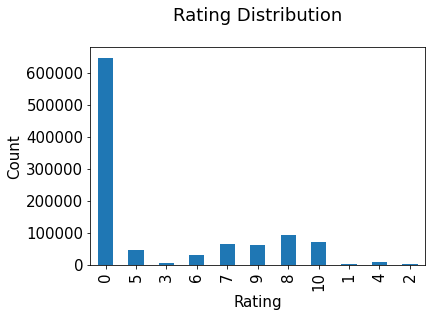

In [54]:
#Bar plot for rating distribution
plt.rc("font", size=15)
ratings_new['Book-Rating'].value_counts(sort=False).plot(kind='bar')
plt.title('Rating Distribution\n')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

As we can see from this above plot The ratings are very unevenly distributed, and the vast majority of ratings are 0 .As quoted in the description of the dataset - BX-Book-Ratings contains the book rating information. Ratings are either explicit, expressed on a scale from 1-10 higher values denoting higher appreciation, or implicit, expressed by 0.Hence segragating implicit and explict ratings datasets.

In [55]:
#Hence segragating implicit and explict ratings datasets
ratings_explicit = ratings_new[ratings_new['Book-Rating'] != 0]
ratings_implicit = ratings_new[ratings_new['Book-Rating'] == 0]

In [56]:
print('ratings_explicit dataset shape',ratings_explicit.shape)
print('ratings_implicit dataset',ratings_implicit.shape)

ratings_explicit dataset shape (383842, 3)
ratings_implicit dataset (647294, 3)


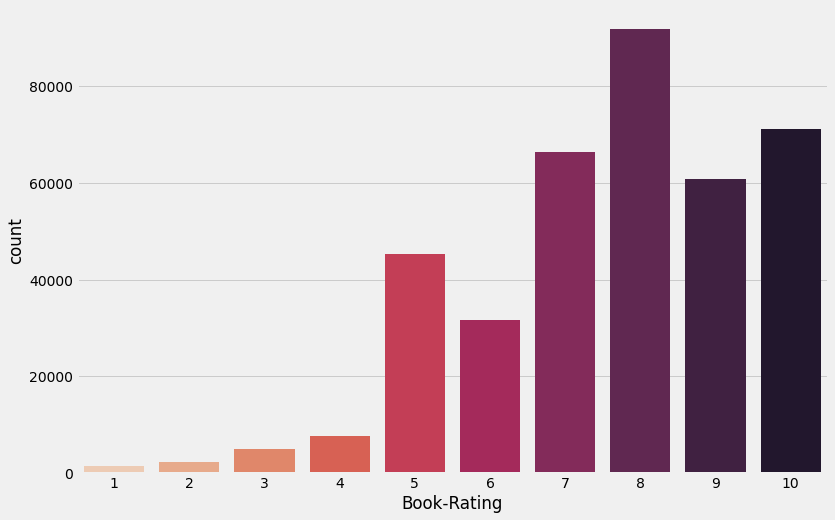

In [57]:
#countplot for explicit ratings
plt.style.use('fivethirtyeight')
plt.figure(figsize=(12, 8))
sns.countplot(data=ratings_explicit , x='Book-Rating', palette='rocket_r')

we can observe that higher ratings are more often amongst users and rating 8 has been rated highest number of times.


In [58]:
# Create column Rating average 
ratings_explicit['Avg_Rating']=ratings_explicit.groupby('ISBN')['Book-Rating'].transform('mean')
# Create column Rating sum
ratings_explicit['Total_No_Of_Users_Rated']=ratings_explicit.groupby('ISBN')['Book-Rating'].transform('count')

In [59]:
ratings_explicit.shape

(383842, 5)

In [60]:
ratings_explicit.head()

,User-ID,ISBN,Book-Rating,Avg_Rating,Total_No_Of_Users_Rated
1,276726,0155061224,5,5.000000,1
3,276729,052165615X,3,3.000000,1
4,276729,0521795028,6,6.000000,1
8,276744,038550120X,7,7.580247,81
16,276747,0060517794,9,8.000000,30



##**Merging All Dataset**

In [61]:
#Dataset merging for complex memory based item-item recommendation
Final_Dataset=users.copy()
Final_Dataset=pd.merge(Final_Dataset,ratings_explicit,on='User-ID')
Final_Dataset=pd.merge(Final_Dataset,books,on='ISBN')

In [62]:
#recheck missing values
missing_values(Final_Dataset)

,index,Missing Values,% of Total Values,Data_type
0,User-ID,0,0.0,int64
1,Age,0,0.0,float64
2,Country,0,0.0,object
3,ISBN,0,0.0,object
4,Book-Rating,0,0.0,int64
5,Avg_Rating,0,0.0,float64
6,Total_No_Of_Users_Rated,0,0.0,int64
7,Book-Title,0,0.0,object
8,Book-Author,0,0.0,object
9,Year-Of-Publication,0,0.0,float64


In [63]:
#checking the shape
Final_Dataset.shape

(383842, 11)

#**Recommendation for New Users(Cold Start)**
As we all know that collaborative filtering have cold start problem so it can't recommend books for fresh new user. So we can recommend them our top read/rated books as a new user.





**Popularity Based Recommendation for new users :**

***Cons**- The Popularity based recommender provide a general chart of recommended books to all the users. They are not sensitive to the interests and tastes of a particular user.

##Top Selling Books-

In [64]:
#Top Selling books
most_selling_isbn=ratings_explicit.groupby('ISBN')['Book-Rating'].count().reset_index()
most_selling_isbn=most_selling_isbn.sort_values(by=['Book-Rating'], ascending=False)
top_selling_books_summary = pd.merge(most_selling_isbn,books, on='ISBN')
top_selling_books_summary['Times_Book_Bought']=top_selling_books_summary['Book-Rating']  #Making a column for better showing in graph
top_selling_books_summary.head(5)

,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Times_Book_Bought
0,0316666343,707,The Lovely Bones: A Novel,Alice Sebold,2002.0,"Little, Brown",707
1,0971880107,581,Wild Animus,Rich Shapero,2004.0,Too Far,581
2,0385504209,487,The Da Vinci Code,Dan Brown,2003.0,Doubleday,487
3,0312195516,383,The Red Tent (Bestselling Backlist),Anita Diamant,1998.0,Picador USA,383
4,0060928336,320,Divine Secrets of the Ya-Ya Sisterhood: A Novel,Rebecca Wells,1997.0,Perennial,320


Text(0.5, 1.0, 'Top 10 Top-Selling Books')

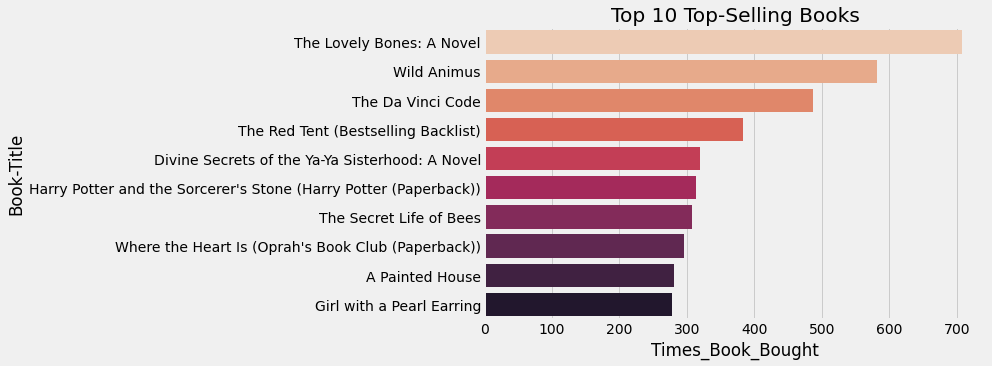

In [65]:
#countplot for Most read books
plt.style.use('fivethirtyeight')
plt.figure(figsize=(8,5))
sns.barplot(y='Book-Title',x='Times_Book_Bought',data=top_selling_books_summary.head(10), palette='rocket_r')
plt.title('Top 10 Top-Selling Books')

These are our top selling books on the basis of how much time it readed by customers.

##Now Let's go for Top Rated Books-

In [66]:
top_rated_isbn=Final_Dataset.groupby('ISBN')['Book-Rating'].sum().reset_index()
top_rated_isbn=top_rated_isbn.sort_values(by=['Book-Rating'], ascending=False)
most_rated_books_summary = pd.merge(top_rated_isbn,books, on='ISBN')
most_rated_books_summary['Overall_Book_Rating']=most_rated_books_summary['Book-Rating']  #Making a column for better showing in graph
most_rated_books_summary.head(5)

,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Overall_Book_Rating
0,0316666343,5787,The Lovely Bones: A Novel,Alice Sebold,2002.0,"Little, Brown",5787
1,0385504209,4108,The Da Vinci Code,Dan Brown,2003.0,Doubleday,4108
2,0312195516,3134,The Red Tent (Bestselling Backlist),Anita Diamant,1998.0,Picador USA,3134
3,059035342X,2798,Harry Potter and the Sorcerer's Stone (Harry P...,J. K. Rowling,1999.0,Arthur A. Levine Books,2798
4,0142001740,2595,The Secret Life of Bees,Sue Monk Kidd,2003.0,Penguin Books,2595


Text(0.5, 1.0, 'Top Rated Books')

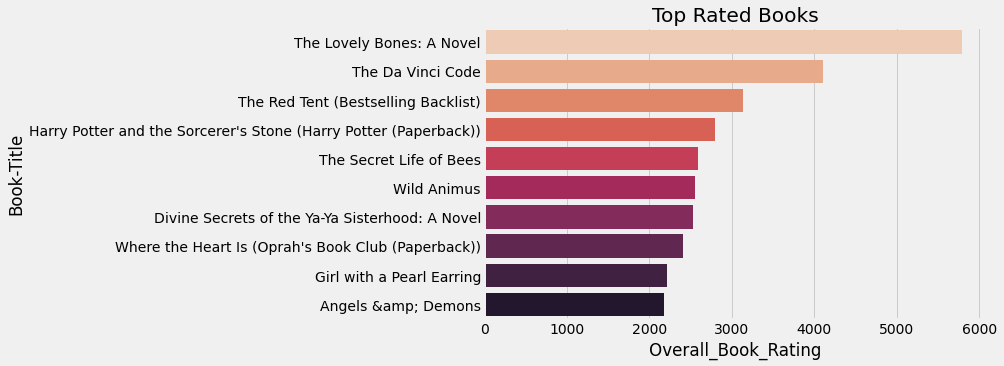

In [67]:
#countplot for Top Rated
plt.style.use('fivethirtyeight')
plt.figure(figsize=(8,5))
sns.barplot(y='Book-Title',x='Overall_Book_Rating',data=most_rated_books_summary.head(10), palette='rocket_r')
plt.title('Top Rated Books')

These are the top books which have highest overall rating.

##Now let's go for Top Rated and Top Selling Books at the same time-

In [68]:
top_df=ratings_explicit[['ISBN','Avg_Rating','Total_No_Of_Users_Rated']]
top_selling_rated_books=top_df[top_df['Total_No_Of_Users_Rated']>250].sort_values(by=['Avg_Rating','Total_No_Of_Users_Rated'],ascending=False)
top_selling_rated_books = top_selling_rated_books.drop_duplicates(subset=['ISBN', 'Avg_Rating','Total_No_Of_Users_Rated'])
top_selling_rated_books_summary = pd.merge(top_selling_rated_books,books, on='ISBN')
top_selling_rated_books_summary.head(5)

,ISBN,Avg_Rating,Total_No_Of_Users_Rated,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,059035342X,8.939297,313,Harry Potter and the Sorcerer's Stone (Harry P...,J. K. Rowling,1999.0,Arthur A. Levine Books
1,0142001740,8.452769,307,The Secret Life of Bees,Sue Monk Kidd,2003.0,Penguin Books
2,0385504209,8.435318,487,The Da Vinci Code,Dan Brown,2003.0,Doubleday
3,0316666343,8.185290,707,The Lovely Bones: A Novel,Alice Sebold,2002.0,"Little, Brown"
4,0312195516,8.182768,383,The Red Tent (Bestselling Backlist),Anita Diamant,1998.0,Picador USA


In [69]:
cm=sns.light_palette('green',as_cmap=True)
#Sorting books based on score calculated above
#Printing the top 10 books
top_selling_rated_books_summary[['Book-Title', 'Publisher', 'Total_No_Of_Users_Rated', 'Avg_Rating']].head(10).style.background_gradient(cmap=cm)

,Book-Title,Publisher,Total_No_Of_Users_Rated,Avg_Rating
0,Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback)),Arthur A. Levine Books,313,8.939297
1,The Secret Life of Bees,Penguin Books,307,8.452769
2,The Da Vinci Code,Doubleday,487,8.435318
3,The Lovely Bones: A Novel,"Little, Brown",707,8.185290
4,The Red Tent (Bestselling Backlist),Picador USA,383,8.182768
5,Where the Heart Is (Oprah's Book Club (Paperback)),Warner Books,295,8.142373
6,Angels & Demons,Pocket Star,269,8.100372
7,Girl with a Pearl Earring,Plume Books,278,7.982014
8,Divine Secrets of the Ya-Ya Sisterhood: A Novel,Perennial,320,7.887500
9,Snow Falling on Cedars,Vintage Books USA,256,7.808594


These are top 10 books which have highest rating and also have highest read count at the same time.

## Recommendation for New Users on the basis of Weighted Average

As the name suggests these top recommendation system works with the trend. It basically uses the items which are in trend right now. For example, if any book which is usually bought by every new user then there are chances that it may suggest that book to the user who just signed up.<br>
Book weighted avg formula:<br>

**Weighted Rating(WR)=[vR/(v+m)]+[mC/(v+m)]**<br>

Where-:<br>
v is the number of votes for the books;<br>
m is the minimum votes required to be listed in the chart;<br>
R is the average rating of the book; and<br>
C is the mean vote across the whole report.<br>

Now we have to find the values of v,m,R,C. Let's go fot it---

In [70]:
#Defining C and m
C= Final_Dataset['Avg_Rating'].mean()
m= Final_Dataset['Total_No_Of_Users_Rated'].quantile(0.90)
Top_Books = Final_Dataset.loc[Final_Dataset['Total_No_Of_Users_Rated'] >= m]
print(f'C={C} , m={m}')
Top_Books.shape

C=7.626700569505161 , m=64.0


(38570, 11)

###Explaination :

In the above m variable we used 90th percentile as our cutoff. In other words, for a book to feature in the charts, it must have more votes than at least 90% of the books in the list.<br>

As we saw that there are 38570 books which qualify to be in this list. Now, we need to calculate our metric for each qualified book. To do this, we will define a function, weighted_rating() and define a new feature score, of which we’ll calculate the value by applying this function to our DataFrame of qualified books:


In [71]:
#Make function on formula basis
def weighted_rating(x, m=m, C=C):
    v = x['Total_No_Of_Users_Rated']
    R = x['Avg_Rating']
    return (v/(v+m) * R) + (m/(m+v) * C)
    
 
Top_Books['Score'] = Top_Books.apply(weighted_rating,axis=1)
 
 
#Sorting books based on score calculated above
Top_Books = Top_Books.sort_values('Score', ascending=False)

In [72]:
#Keeping only one entry of each book
Top_Books=Top_Books.sort_values('Score', ascending=False).drop_duplicates('ISBN').sort_index()
cm=sns.light_palette('green',as_cmap=True)
#Sorting books based on score calculated above
Top_Books = Top_Books.sort_values('Score', ascending=False)

#Printing the top 20 books
Top_Books[['Book-Title', 'Total_No_Of_Users_Rated', 'Avg_Rating', 'Score']].reset_index(drop=True).head(20).style.background_gradient(cmap=cm)

,Book-Title,Total_No_Of_Users_Rated,Avg_Rating,Score
0,Harry Potter and the Goblet of Fire (Book 4),137,9.262774,8.741835
1,Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback)),313,8.939297,8.716469
2,Harry Potter and the Order of the Phoenix (Book 5),206,9.033981,8.700403
3,To Kill a Mockingbird,214,8.943925,8.640679
4,Harry Potter and the Prisoner of Azkaban (Book 3),133,9.082707,8.609690
5,"The Return of the King (The Lord of the Rings, Part 3)",77,9.402597,8.596517
6,Harry Potter and the Prisoner of Azkaban (Book 3),141,9.035461,8.595653
7,Harry Potter and the Sorcerer's Stone (Book 1),119,8.983193,8.508791
8,Harry Potter and the Chamber of Secrets (Book 2),189,8.783069,8.490549
9,Harry Potter and the Chamber of Secrets (Book 2),126,8.920635,8.484783


These are our top books on the basis of formula base-weighted ratings.

#**Model Based Collaborative Filtering Recommender**
The goal of the recommender system is to predict user preference for a set of items based on the past experience. Two the most popular approaches are Content-Based and Collaborative Filtering.
<br>Collaborative filtering is a technique used by websites like Amazon, YouTube, and Netflix. It filters out items that a user might like on the basis of reactions of similar users. There are two categories of collaborative filtering algorithms: memory based and model based.
<br>
Model based approach involves building machine learning algorithms to predict user's ratings. They involve dimensionality reduction methods that reduce high dimensional matrix containing abundant number of missing values with a much smaller matrix in lower-dimensional space.
<br>
The goal of this section is to compare SVD and NMF algorithms, try different configurations of parameters and explore obtained results.

##Preparation

In [73]:
import scipy
import math
import sklearn
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt

This analysis will focus on book recommendations based on Book-Crossing dataset. To reduce the dimensionality of the dataset and avoid running into memory error we will focus on users with at least 3 ratings and top 10% most frequently rated books. 
<br>
The recommender systems will be built using surprise package (Matrix Factorization - based models).

In [74]:
ratings_explicit

,User-ID,ISBN,Book-Rating,Avg_Rating,Total_No_Of_Users_Rated
1,276726,0155061224,5,5.000000,1
3,276729,052165615X,3,3.000000,1
4,276729,0521795028,6,6.000000,1
8,276744,038550120X,7,7.580247,81
16,276747,0060517794,9,8.000000,30
...,...,...,...,...,...
1149771,276704,0743211383,7,6.964912,57
1149773,276704,0806917695,5,5.000000,1
1149775,276704,1563526298,9,7.000000,3
1149777,276709,0515107662,10,8.444444,18


In [75]:
#Rename the columns for easiness of understanding  
ratings_explicit.rename(columns = {'User-ID':'user_id' ,'ISBN':'isbn' ,'Book-Rating':'book_rating'},inplace=True)

In [76]:
user_ratings_threshold = 3

filter_users = ratings_explicit['user_id'].value_counts()
filter_users_list = filter_users[filter_users >= user_ratings_threshold].index.to_list()

df_ratings_top = ratings_explicit[ratings_explicit['user_id'].isin(filter_users_list)]

print('Filter: users with at least %d ratings\nNumber of records: %d' % (user_ratings_threshold, len(df_ratings_top)))

Filter: users with at least 3 ratings
Number of records: 327271


In [77]:
book_ratings_threshold_perc = 0.1
book_ratings_threshold = len(df_ratings_top['isbn'].unique()) * book_ratings_threshold_perc

filter_books_list = df_ratings_top['isbn'].value_counts().head(int(book_ratings_threshold)).index.to_list()
df_ratings_top = df_ratings_top[df_ratings_top['isbn'].isin(filter_books_list)]

print('Filter: top %d%% most frequently rated books\nNumber of records: %d' % (book_ratings_threshold_perc*100, len(df_ratings_top)))

Filter: top 10% most frequently rated books
Number of records: 160787




##SVD and NMF models comparison

Singular Value Decomposition (SVD) and Non-negative Matrix Factorization (NMF) are matrix factorization techniques used for dimensionality reduction. Surprise package provides implementation of those algorithms.


In [78]:
pip install surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.8 MB 4.1 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1633986 sha256=f4bd4c445570886d4eae02e0359d4cf47d80511a9dff86aff9c070666dab0a35
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


In [79]:
from surprise import Dataset, Reader
from surprise import SVD, NMF
from surprise.model_selection import cross_validate, train_test_split, GridSearchCV

In [80]:
df=df_ratings_top.copy()
reader = Reader(rating_scale=(1, 10))
data = Dataset.load_from_df(df[['user_id', 'isbn', 'book_rating']], reader)

In [81]:
data

In [82]:
model_svd = SVD()
cv_results_svd = cross_validate(model_svd, data, cv=3)
pd.DataFrame(cv_results_svd).mean()

test_rmse     1.600470
test_mae      1.238534
fit_time     10.343655
test_time     0.929151
dtype: float64

In [83]:
model_nmf = NMF()
cv_results_nmf = cross_validate(model_nmf, data, cv=3)
pd.DataFrame(cv_results_nmf).mean()

test_rmse     2.618939
test_mae      2.234966
fit_time     11.548717
test_time     0.656570
dtype: float64


It's clear that for the given dataset much better results can be obtained with SVD approach - both in terms of accuracy and training / testing time.

##**Optimisation of SVD algorithm**<br>
Grid Search Cross Validation computes accuracy metrics for an algorithm on various combinations of parameters, over a cross-validation procedure. It's useful for finding the best configuration of parameters.
<br>
It is used to find the best setting of parameters:
<br>
n_factors - the number of factors<br>
n_epochs - the number of iteration of the SGD procedure<br>
lr_all - the learning rate for all parameters<br>
reg_all - the regularization term for all parameters<br>
As a result, regarding the majority of parameters, the default setting is the most optimal one.

In [84]:
param_grid = {'n_factors': [80,100],
              'n_epochs': [5, 20],
              'lr_all': [0.002, 0.005],
              'reg_all': [0.2, 0.4]}

gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)
gs.fit(data)

print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

1.5959573620227523
{'n_factors': 80, 'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.2}


 The improvement obtained with Grid Search is very small.


Analysis of Collaborative Filtering model results
In this part, let's examine in detail the results obtained by the SVD model that provided the best RMSE score.

##Analysis of Collaborative Filtering model-based results-
In this part, let's examine in detail the results obtained by the SVD model that provided the best RMSE score.

In [85]:
trainset, testset = train_test_split(data, test_size=0.2)

model = SVD(n_factors=80, n_epochs=20, lr_all=0.005, reg_all=0.2)
model.fit(trainset)
predictions = model.test(testset)

In [86]:
df_pred = pd.DataFrame(predictions, columns=['user_id', 'isbn', 'actual_rating', 'pred_rating', 'details'])
df_pred['impossible'] = df_pred['details'].apply(lambda x: x['was_impossible'])
df_pred['pred_rating_round'] = df_pred['pred_rating'].round()
df_pred['abs_err'] = abs(df_pred['pred_rating'] - df_pred['actual_rating'])
df_pred.drop(['details'], axis=1, inplace=True)
df_pred.sample(5)

,user_id,isbn,actual_rating,pred_rating,impossible,pred_rating_round,abs_err
26798,150617,006091565X,7.0,7.328616,False,7.0,0.328616
28750,188010,0062502182,6.0,7.876812,False,8.0,1.876812
3107,11676,0425148297,10.0,7.284223,False,7.0,2.715777
18708,75591,0385475713,10.0,8.491529,False,8.0,1.508471
15853,269738,0380780860,8.0,7.375691,False,7.0,0.624309


Distribution of actual and predicted ratings in the test set
According to the distribution of actual ratings of books in the test set, the biggest part of users give positive scores - between 7 and 10. The mode equals 8 but count of ratings 7, 9, 10 is also noticeable. The distribution of predicted ratings in the test set is visibly different. One more time, 8 is a mode but scores 7, 9 and 10 are clearly less frequent.
<br>
It shows that the recommender system is not perfect and it cannot reflect the real distribution of book ratings.

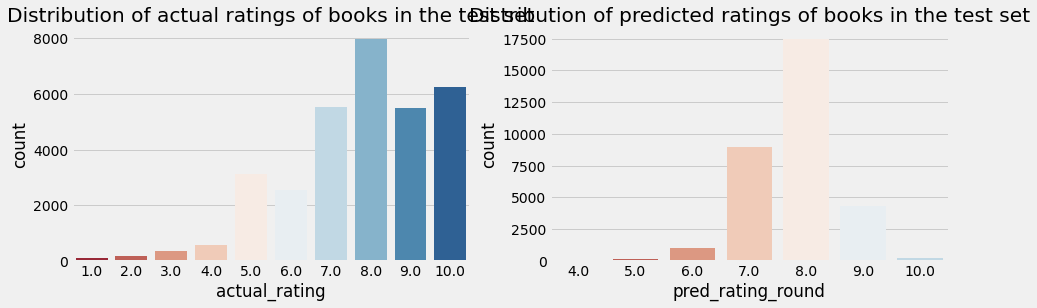

In [87]:
palette = sns.color_palette("RdBu", 10)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))

sns.countplot(x='actual_rating', data=df_pred, palette=palette, ax=ax1)
ax1.set_title('Distribution of actual ratings of books in the test set')

sns.countplot(x='pred_rating_round', data=df_pred, palette=palette, ax=ax2)
ax2.set_title('Distribution of predicted ratings of books in the test set')

plt.show()

Absolute error of predicted ratings**<br>
The distribution of absolute errors is right-skewed, showing that the majority of errors is small: between 0 and 1. There is a long tail that indicates that there are several observations for which the absolute error was close to 10.
<br>
How good/bad the model is with predicting certain scores? As expected from the above charts, the model deals very well with predicting score = 8 (the most frequent value). The further the rating from score = 8, the higher the absolute error. The biggest errors happen to observations with scores 1 or 2 which indicates that probably the model is predicting high ratings for those observations.

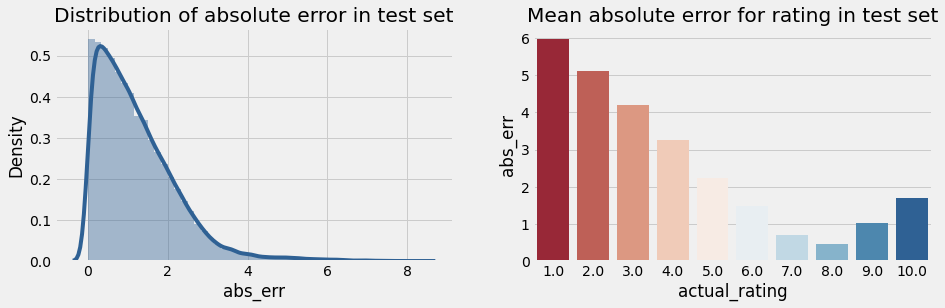

In [88]:
df_pred_err = df_pred.groupby('actual_rating')['abs_err'].mean().reset_index()

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))

sns.distplot(df_pred['abs_err'], color='#2f6194', ax=ax1)
ax1.set_title('Distribution of absolute error in test set')

sns.barplot(x='actual_rating', y='abs_err', data=df_pred_err, palette=palette, ax=ax2)
ax2.set_title('Mean absolute error for rating in test set')

plt.show()


Analysis of predicted ratings of a particular user<br>
For this part of the analysis, the user with id 193458 was selected. By analyzing book ratings by this user, it can be noted that he/she likes diverse types of readings: English romantic novels (Pride and Prejudice, Sense and Sensibility), fantasy (Narnia) as well as historical novels (Schindler's List). Among the recommended books there are other works from Narnia's series, two historical novels and one romance which correlates with user's previous preferences.

In [89]:
df_books = books.copy()
df_books.rename(columns = {'ISBN':'isbn' ,'Book-Title':'book_title'},inplace=True)
df_ext = df.merge(df_books[['isbn', 'book_title']], on='isbn', how='left')
df_ext = df_ext.merge(df_pred[['isbn', 'user_id', 'pred_rating']], on=['isbn', 'user_id'], how='left')

In [90]:
df_ext

,user_id,isbn,book_rating,Avg_Rating,Total_No_Of_Users_Rated,book_title,pred_rating
0,276747,0060517794,9,8.000000,30,Little Altars Everywhere,8.037790
1,276747,0671537458,9,7.176471,17,Waiting to Exhale,NaN
2,276747,0679776818,8,7.476190,21,Birdsong: A Novel of Love and War,NaN
3,276772,0553572369,7,6.625000,8,Pay Dirt (Mrs. Murphy Mysteries (Paperback)),7.635369
4,276772,3499230933,10,7.166667,6,Adressat unbekannt.,NaN
...,...,...,...,...,...,...,...
160782,276688,0836218655,10,8.086957,23,Wiener Dog Art,NaN
160783,276688,0836236688,10,8.333333,15,Dilbert: Seven Years Of Highly Defective Peopl...,8.175542
160784,276688,1551669315,6,7.200000,5,The Third Wife,NaN
160785,276704,0345386108,6,6.852941,34,Winter Moon,7.418691


####Train set: Top rated books

In [91]:
selected_user_id = 193458
df_user = df_ext[df_ext['user_id']==selected_user_id]

df_user[(df_user['pred_rating'].isna())&(df_user['book_rating']>=9)].sample(10)

,user_id,isbn,book_rating,Avg_Rating,Total_No_Of_Users_Rated,book_title,pred_rating
113593,193458,0345342569,9,7.947368,19,Shoeless Joe,NaN
113583,193458,014011369X,9,9.125000,8,"And the Band Played on: Politics, People, and ...",NaN
113585,193458,0140620125,9,8.133333,15,Wuthering Heights (Penguin Popular Classics),NaN
113619,193458,0671880314,9,8.305556,36,Schindler's List,NaN
113592,193458,0330352695,9,7.615385,13,Four Letters of Love,NaN
113587,193458,0142001740,9,8.452769,307,The Secret Life of Bees,NaN
113594,193458,0345361792,10,8.607735,181,A Prayer for Owen Meany,NaN
113584,193458,0140298479,9,7.539823,113,Bridget Jones: The Edge of Reason,NaN
113599,193458,0345431057,9,9.125000,8,Slaves in the Family (Ballantine Reader's Circle),NaN
113630,193458,1853260169,10,8.153846,13,Sense and Sensibility (Wordsworth Classics),NaN


In [92]:
df_pred

,user_id,isbn,actual_rating,pred_rating,impossible,pred_rating_round,abs_err
0,268191,0140075623,8.0,8.248883,False,8.0,0.248883
1,103251,1552781542,3.0,7.489436,False,7.0,4.489436
2,268492,0060092661,5.0,7.246990,False,7.0,2.246990
3,232131,0316103098,8.0,7.571766,False,8.0,0.428234
4,88937,0446672211,8.0,7.771825,False,8.0,0.228175
...,...,...,...,...,...,...,...
32153,78323,0345419995,5.0,7.592984,False,8.0,2.592984
32154,44594,0345459202,9.0,8.087150,False,8.0,0.912850
32155,266478,0441533825,4.0,7.715746,False,8.0,3.715746
32156,80061,3404121686,6.0,8.145094,False,8.0,2.145094


###Test set: Top rated books


####Test set: predicted top rated books

In [93]:
df_user[df_user['pred_rating'].notna()].sort_values('pred_rating', ascending=False).head(5)

,user_id,isbn,book_rating,Avg_Rating,Total_No_Of_Users_Rated,book_title,pred_rating
113579,193458,0064471071,9,8.733333,15,The Voyage of the Dawn Treader (rack) (Narnia),8.355961
113580,193458,006447108X,9,8.833333,18,The Last Battle,8.216040
113602,193458,0399145923,6,7.833333,24,Carolina Moon,8.182236
113631,193458,1853260622,5,8.272727,11,War and Peace (Wordsworth Classics),8.176170
113615,193458,0553258001,9,8.236842,38,The Cider House Rules,8.156926


####Test set: actual top rated books

In [94]:
df_user[df_user['pred_rating'].notna()].sort_values('book_rating', ascending=False).head(5)

,user_id,isbn,book_rating,Avg_Rating,Total_No_Of_Users_Rated,book_title,pred_rating
113579,193458,0064471071,9,8.733333,15,The Voyage of the Dawn Treader (rack) (Narnia),8.355961
113580,193458,006447108X,9,8.833333,18,The Last Battle,8.216040
113615,193458,0553258001,9,8.236842,38,The Cider House Rules,8.156926
113620,193458,0679429220,9,7.794393,107,Midnight in the Garden of Good and Evil: A Sav...,7.800880
113586,193458,0140620206,8,7.416667,12,Tess of the Durbervilles,7.838522


#**Content Based Filtering Recommender**

For Content Based Book Recommendation we have to use NLP techniques like Keyword extraction -> Extract keywords from title Cosine Similarity -> Find cosine similarity between all book titles.

Keyword Extraction- Keyword extraction is automatic detection of terms that best describe the subject of a document.

For keyword extraction we try both of the below,

**CountVectorizer** - Provides a simple way to both tokenize a collection of text documents and build a vocabulary of known words, but also to encode new documents using that vocabulary.

**Tf-Idf Vectorizer** - Tf-Idf finds the no. of times a word occurs in a document and then compares this count to the no. of times the word shows up in a bunch of other documents in a collection. It then generates a rank for each word where it is important to a document if it shows up a lot in that particular document but doesn’t show up a lot in all the other documents. 

First we will use CountVectorizer as we want to extract keywords just from book titles.

Let's Take only first 10K rows so our server wouldn't be crashed during processing

In [95]:
#Make a new book df with the first 10k rows of books df so our server wouldn't be crashed during processing
book=books.iloc[0:10000,:]

##Content-Based Recommendation on the basis of Search Keyword(Tags, Book-name,Author-name,Publication-name)

In [96]:
#Make a copy of book of 10k's df 
book1=book.copy()

###via Tf-idf vectorizer

In [97]:
#Checking out it's column
book1.columns

Index(['ISBN', 'Book-Title', 'Book-Author', 'Year-Of-Publication',
       'Publisher'],
      dtype='object')

Recommendation of books using the authors,publications and title attributes for better results. Creating corpus of features and calculating the TF-IDF on the corpus of attributes for gettings better recommendations.

In [98]:
#Making a corpus column by joining Book-author, book-title and book publishers
book1['corpus'] = (pd.Series(book1[['Book-Author', 'Book-Title','Publisher']]
                .fillna('')
                .values.tolist()
                ).str.join(' '))

In [99]:
#Applying Vectorizer
tf_corpus = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix_corpus = tf_corpus.fit_transform(book1['corpus'])
cosine_sim_corpus = linear_kernel(tfidf_matrix_corpus, tfidf_matrix_corpus)

# Build a 1-dimensional array with book titles
titles = book1['Book-Title']
indices = pd.Series(book1.index, index=book1['Book-Title'])

# Function that get book recommendations based on the cosine similarity score of books tags
def corpus_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim_corpus[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:21]
    book_indices = [i[0] for i in sim_scores]
    return titles.iloc[book_indices]

In [100]:
corpus_recommendations('Clara Callan')

2084                                         Keeper n' Me
9427                                          Wildblossom
6206                                         Going Native
3873                          Der Gesang des Troubadours.
6395                                 There Will Be Wolves
5612                                 Why I Hate Canadians
9767                                The Dollhouse Murders
6335    The SEARCH FOR SNOUT: BRUCE COVILLE'S ALIEN AD...
4239                      The Lion, the Fox and the Eagle
6392                                     Thirteenth Child
7831                       Dones (ColÂ¨lecciÃ³ clÃ ssica)
7484                                 What Am I Doing Here
676                                            Globalhead
1015                                The Real Mother Goose
552                                   Going down swinging
1418                               My Teacher is an Alien
2786                                 Distraction: A Novel
8217          

###Via Tags 

In [101]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [102]:
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

In [103]:
#Making a corpus column by joining Book-author, book-title and book publishers
book1['tags'] = (pd.Series(book1[['Book-Author', 'Book-Title','Publisher']]
                .fillna('')
                .values.tolist()
                ).str.join(' '))

In [104]:
# extracting the stopwords from nltk library
sw = stopwords.words('english')
# displaying the stopwords
np.array(sw)

array(['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you',
       "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself',
       'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her',
       'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them',
       'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom',
       'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are',
       'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had',
       'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and',
       'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at',
       'by', 'for', 'with', 'about', 'against', 'between', 'into',
       'through', 'during', 'before', 'after', 'above', 'below', 'to',
       'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under',
       'again', 'further', 'then', 'once', 'here', 'there', 'when',
       'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'm

In [105]:
#Making necessory function for applying on tags column for better results
def remove_punctuation(text):
    '''a function for removing punctuation'''
    import string
    # replacing the punctuations with no space, 
    # which in effect deletes the punctuation marks 
    translator = str.maketrans('', '', string.punctuation)
    # return the text stripped of punctuation marks
    return text.translate(translator)

    
def stopwords(text):
    '''a function for removing the stopword'''
    # removing the stop words and lowercasing the selected words
    text = [word.lower() for word in text.split() if word.lower() not in sw]
    # joining the list of words with space separator
    return " ".join(text)


# create an object of stemming function
stemmer = SnowballStemmer(language='english')

def stemming(text):    
    '''a function which stems each word in the given text'''
    text = [stemmer.stem(word) for word in text.split()]
    return " ".join(text) 

def making_word(text):
  text=text.split()
  return text

def get_list_of_words(text):
  text=remove_punctuation(text)
  text=stopwords(text)
  text=stemming(text)
  text=making_word(text)
  return text

In [106]:
#Making function for applying all function of above
def get_list_of_words(text):
  text=remove_punctuation(text)
  text=stopwords(text)
  text=stemming(text)
  text=making_word(text)
  return text


In [107]:
#Applying functions on our df
book1['tags']=book1['tags'].apply(get_list_of_words)

In [108]:
#Making fubction for getting books according to our customer's search
def getting_books(text):
  text=remove_punctuation(text)
  text=stopwords(text)
  text=stemming(text)
  listt=text.split()
  df=pd.DataFrame()
  output=book1[pd.DataFrame(book1.tags.tolist()).isin(listt).any(1).values]
  df=df.append(output)
  if len(df)<1:
    df='No Results Try Different Search Keyword'
  return df


In [110]:
#Check function acc to user's input
inputted_text=str(input(()))
getting_books(inputted_text)

()Islands in the Net


,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,corpus,tags
224,0440234964,All or Nothing (Wheeler Large Print Books),Elizabeth Adler,2000.0,Island,Elizabeth Adler All or Nothing (Wheeler Large ...,"[elizabeth, adler, noth, wheeler, larg, print,..."
448,0140382658,You Can Surf the Net: Your Guide to the World ...,Marc Gascoigne,1996.0,Puffin Books,Marc Gascoigne You Can Surf the Net: Your Guid...,"[marc, gascoign, surf, net, guid, world, inter..."
467,0870441663,The wild ponies of Assateague Island (Books fo...,Donna K Grosvenor,1975.0,National Geographic Society,Donna K Grosvenor The wild ponies of Assateagu...,"[donna, k, grosvenor, wild, poni, assateagu, i..."
585,0345441133,Summer Island,KRISTIN HANNAH,2002.0,Ballantine Books,KRISTIN HANNAH Summer Island Ballantine Books,"[kristin, hannah, summer, island, ballantin, b..."
888,0440218535,Smilla's Sense of Snow,Peter Hoeg,1997.0,Island,Peter Hoeg Smilla's Sense of Snow Island,"[peter, hoeg, smilla, sens, snow, island]"
948,0425161722,Net Force,Tom Clancy,1999.0,Berkley Publishing Group,Tom Clancy Net Force Berkley Publishing Group,"[tom, clanci, net, forc, berkley, publish, group]"
965,0440222818,Guilt,John T. Lescroart,1998.0,Island,John T. Lescroart Guilt Island,"[john, lescroart, guilt, island]"
1350,0140259198,The Island of the Day Before,Umberto Eco,1996.0,Penguin Books,Umberto Eco The Island of the Day Before Pengu...,"[umberto, eco, island, day, penguin, book]"
1585,0440940001,Island of the Blue Dolphins (Laurel Leaf Books),Scott O'Dell,1978.0,Laure Leaf,Scott O'Dell Island of the Blue Dolphins (Laur...,"[scott, odel, island, blue, dolphin, laurel, l..."
1779,0380727501,Notes from a Small Island,Bill Bryson,1997.0,Perennial,Bill Bryson Notes from a Small Island Perennial,"[bill, bryson, note, small, island, perenni]"


##Content-Based Recommendation on the basis of Author

In [111]:
#Make a copy of book of 10k's df 
book2=book.copy()

In [112]:
#Checking The columns
book2.columns

Index(['ISBN', 'Book-Title', 'Book-Author', 'Year-Of-Publication',
       'Publisher'],
      dtype='object')

In [113]:
#checking the head
book2.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,0195153448,Classical Mythology,Mark P. O. Morford,2002.0,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991.0,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999.0,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999.0,W. W. Norton &amp; Company


TfidfVectorizer function from scikit-learn, which transforms text to feature vectors that can be used as input to estimator.

Cosine Similarity to calculate a numeric value that denotes the similarity between two books.

In [114]:
#applying tf-idf vectorizer
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(book2['Book-Author'])


In [115]:
#Applying linear kernal for getting similarity
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)


A function that returns the 20 most similar books based on the cosine similarity score.

In [116]:
# Build a 1-dimensional array with book titles
titles = book2['Book-Title']
indices = pd.Series(book.index, index=book2['Book-Title'])

# Function that get book recommendations based on the cosine similarity score of book authors
def authors_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:21]
    book_indices = [i[0] for i in sim_scores]
    return titles.iloc[book_indices]


In [117]:
#let's check our reommendation
authors_recommendations('Classical Mythology').head(20)

402                          The Adventures of Tom Sawyer
1430    Adventures of Huckleberry Finn (Signet Classic...
1532    Adventures of Huckleberry Finn (Dover Thrift E...
2186          A Connecticut Yankee in King Arthur's Court
2354                       Adventures of Huckleberry Finn
2577                         The Adventures of Tom Sawyer
3624    A Connecticut Yankee in King Arthur's Court (D...
4137    The Adventures of Tom Sawyer (Penguin Popular ...
4177                             Adventures of Tom Sawyer
4700                          The Diaries of Adam and Eve
4701      The Diaries of Adam and Eve (Literary Classics)
6117    Treasury of Illustrated Classics: Adventures o...
7971    The Complete Short Stories of Mark Twain (Bant...
8699    ADVENTURES OF HUCKLEBERRY FINN (ENRICHED CLASS...
9175    A Connecticut Yankee in King Arthur's Court (B...
9664    The Adventures of Tom Sawyer (Illustrated Libr...
1670                             Fishboy: A Ghost's Story
8568          

In [118]:
#checking if our reccommendation is doing good or not
book.iloc[402]

ISBN                                     0812504208
Book-Title             The Adventures of Tom Sawyer
Book-Author                              Mark Twain
Year-Of-Publication                          1989.0
Publisher                                 Tor Books
Name: 402, dtype: object

In [119]:
#checking if our reccommendation is doing good or not
book.iloc[4137]

ISBN                                                          0140620524
Book-Title             The Adventures of Tom Sawyer (Penguin Popular ...
Book-Author                                                   Mark Twain
Year-Of-Publication                                               1994.0
Publisher                                              Penguin Books Ltd
Name: 4137, dtype: object

##Content-Based Recommendation on the basis of Book-Title(with count-vectorizer)

In [120]:
#Make a copy of book of 10k's df 
book3=book.copy()

In [121]:
#checking out it's column
book3.columns

Index(['ISBN', 'Book-Title', 'Book-Author', 'Year-Of-Publication',
       'Publisher'],
      dtype='object')

In [122]:
#Lets vectorize all these titles
#initialize vectorizer
vect = CountVectorizer(analyzer = 'word', ngram_range = (1,2), stop_words = 'english', min_df = 0.002) #min_df = rare words, max_df = most used words
#ngram_range = (1,2) - if used more than  1(value), lots of features or noise

#Fit into the title
vect.fit(book3['Book-Title'])
title_matrix = vect.transform(book3['Book-Title'])
title_matrix.shape

(10000, 267)

In [123]:
#Lets find vocabulary/features
features = vect.get_feature_names()
len(features)

267

In [124]:
#applying cosine similarity
cosine_sim_titles = cosine_similarity(title_matrix, title_matrix)
cosine_sim_titles.shape

(10000, 10000)

In [125]:
#Get books which are similar to a given title
title_id = 10
book3['Book-Title'].iloc[title_id]


'Nights Below Station Street'

In [126]:
#Find out what features have been considered  by the vectorizer for a given title ?
feature_array = np.squeeze(title_matrix[title_id].toarray()) #squeeze activity matrix into array
idx = np.where(feature_array > 0)
idx[0]
[features[x] for x in idx[0]]

['street']

In [127]:
# Find index of feature
idx[0]

array([219])

In [128]:
#Cosine similarity with other similar titles
n = 15 #how many books to be recommended
top_n_idx = np.flip(np.argsort(cosine_sim_titles[title_id,]), axis = 0)[0:n]
top_n_sim_values = cosine_sim_titles[title_id, top_n_idx]
top_n_sim_values

array([1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       0.70710678, 0.70710678, 0.70710678, 0.70710678, 0.70710678])

In [129]:
#find top n with values > 0
top_n_idx = top_n_idx[top_n_sim_values > 0]
#Matching books
book3['Book-Title'].iloc[top_n_idx]

5050                         On the Street Where You Live
52                                      The Street Lawyer
4256                             The Cater Street Hangman
4300                               Perdido Street Station
6149                                         Union Street
2268                                    The Street Lawyer
3220                                        Eureka Street
588                                     The Street Lawyer
10                            Nights Below Station Street
9686    Liar's Poker: Rising Through the Wreckage on W...
8813    COLLEGE WEEKEND: FEAR STREET #32 : COLLEGE WEE...
4271    The Coffeehouse Investor: How to Build Wealth,...
956     Wall Street's Picks for 2000: An Insider's Gui...
7850                                House On Olive Street
2518    The Wall Street Journal Lifetime Guide to Mone...
Name: Book-Title, dtype: object

As we can see all the books with similar to 'Street' will be recommended by this recommendation.

Now let's make a function for above code-

In [130]:
# lets wrap the above code in a function
def return_sim_books(title_id):
    print ("For Book = {}, Our Recommendation is :".format(book3['Book-Title'][title_id])) 
    top_n = 10
    vectorizer = CountVectorizer(analyzer='word',ngram_range=(1,2),stop_words='english', min_df = 0.001)
    vectorizer.fit(book3['Book-Title'])
    title_matrix = vectorizer.transform(book3['Book-Title'])
    
    # generate sim matrix
    sim_matrix = cosine_similarity(title_matrix, title_matrix)
    features = vectorizer.get_feature_names()

    top_n_idx = np.flip(np.argsort(sim_matrix[title_id,]),axis=0)[0:top_n]
    top_n_sim_values = sim_matrix[title_id, top_n_idx]
    
    # find top n with values > 0
    top_n_idx = top_n_idx[top_n_sim_values > 0]
    scores = top_n_sim_values[top_n_sim_values > 0]
    
    
    # find features from the vectorized matrix
    sim_books_idx = book3['Book-Title'].iloc[top_n_idx].index
    words = []
    for book_idx in sim_books_idx:
        try:
            feature_array = np.squeeze(title_matrix[book_idx,].toarray())
        except:
            feature_array = np.squeeze(title_matrix[book_idx,])
        idx = np.where(feature_array > 0)
        words.append([" , ".join([features[i] for i in idx[0]])])
        
    #collate results
    res = pd.DataFrame({        
           "sim_books": book3['Book-Title'].iloc[top_n_idx].values,"words":words,
           "scores":scores}, columns = ["sim_books","scores","words"]) #for print book name which we want to show similar with,
                                                                      # in this df use this as first col-"book_title" : books_title['title'].iloc[title_id], and add one more column 
    return res


In [131]:
book3

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,0195153448,Classical Mythology,Mark P. O. Morford,2002.0,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991.0,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999.0,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999.0,W. W. Norton &amp; Company
...,...,...,...,...,...
9995,0380730774,Read This and Tell Me What It Says : Stories (...,A. Manette Ansay,1998.0,William Morrow
9996,0862418879,The Star Rover,Jack London,2000.0,Canongate Books
9997,340414645X,Die Keltennadel.,Patrick Dunne,2001.0,LÃ?Â¼bbe
9998,3442730988,Tod in der Datscha.,Anna Malyschewa,2003.0,btb


In [132]:
# Let's check out our similar books function
return_sim_books(9996)

For Book = The Star Rover, Our Recommendation is :


,sim_books,scores,words
0,Star,1.000000,[star]
1,The Star Rover,1.000000,[star]
2,Polar Star,1.000000,[star]
3,"Evening Star (Sam Keaton:Legends of Laramie, 1)",1.000000,[star]
4,Linda Goodman's Star Signs,1.000000,[star]
5,Troubling a Star,1.000000,[star]
6,Delta Star,1.000000,[star]
7,Hidden Star (The Star Series),0.816497,"[hidden , series , star]"
8,Star Country,0.707107,"[country , star]"
9,Child Star,0.707107,"[child , star]"


##Content-Based Recommendation on the basis of Book-Puchase history list

In [133]:
my_list=['House On Olive Street','The Star Rover']

In [134]:
result = pd.DataFrame()
n = 5 #Recommend top n similar books
print('Recommended books: ')
for i in my_list:
    output = pd.DataFrame(return_sim_books(book3.index[book3['Book-Title'] == i][0]))
    result = result.append(output)
    result = result.drop_duplicates(subset=['sim_books'])
result= result.sample(n=20).reset_index()   #for mixing up rows with each other or pickup random rows and reset index
result

Recommended books: 
For Book = House On Olive Street, Our Recommendation is :
For Book = The Star Rover, Our Recommendation is :


,index,sim_books,scores,words
0,8,Perdido Street Station,0.707107,[street]
1,2,Polar Star,1.000000,[star]
2,9,Child Star,0.707107,"[child , star]"
3,1,The Star Rover,1.000000,[star]
4,0,House On Olive Street,1.000000,"[house , street]"
5,1,The House on Mango Street,1.000000,"[house , street]"
6,5,Troubling a Star,1.000000,[star]
7,6,Someone in the House,0.707107,[house]
8,6,Delta Star,1.000000,[star]
9,8,Star Country,0.707107,"[country , star]"


#Conclusion


Alas! We have reached the end of our notebook.

For this project our client is an online book selling firm. They now need assistance in developing a model to recommend another books on the basis of customer purchase-history and other information which are given in the datasets.

Building a model to recommend another books is extremely beneficial to the company because it can increase their sales via recommend relevant books to their customers and optimise its business model and revenue accordingly.

* For modelling, it was observed that for **model based** collaborative filtering SVD technique worked way better than NMF with lower Mean Absolute Error (MAE) .<br>
* Amongst the memory based approach, **item-item CF performed better** than **user-item CF** because of lower computation.
* Content-based recommendation on the basis of **Tags** are also doing good in terms of results.

###Key points:

*   Customers of age between 20 to 30 are more likely to buy books.

*   Customers who are in USA are more likely to buy books than others.

*   Our overall top selling authors are Agatha Cristie, William Shakespeare and Stephen King.

*   If we look at the ratings distribution, most of the books have high ratings with maximum books being rated 8. Ratings below 5 are few in number.

*   Our overall top selling publishers are Harlequin, Silhouette and Pocket.

*   Our overall top selling books are The Lovely Bones: A Novel, Wild Animus and The Da Vinci Code, The Red Tent (Bestselling Backlist).
.

###Improvements:

1. By using a marketing and advertising approach, we can reduce the age-gap.

2. We can clearly see that we have a larger number of buyer within USA, therefore we can easily recommend books to them on the basis of location and use this starategy for our campaign.

3. We nearly make 10 recommender system from which we can select Best according to our Business-needs.

4. We can push those type of books to publish which are similar to our top-selling books and recommend them to our Users.

##Future Work

*   We can recommend books to our customers on basis of genres also but we have no information on that so we have to record books genres also for better recommendation.
*   We can also record Date-time of our users when they buy book, By using that we can recommend our top books, authors, publication on monthly basis.